# This is a part of the **practical exercise** on uncertainty for dermatoscopy classification. Your task is to go through this tutorial and fill in missing code and answer the questions.

---

First, as usual, we load needed libraries.

---


In [ ]:

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
from torchvision.transforms import ToTensor, Lambda

import numpy as np

In [ ]:
!pip install medmnist

---

Now, let's load the dermatoscopy dataset from MedMNIST.

---



In [ ]:
import medmnist
from medmnist import INFO, Evaluator

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
data_flag = 'dermamnist'
info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

train_set = DataClass(split='train', transform=data_transform, download=True)
test_set = DataClass(split='test', transform=data_transform, download=True)
train_set

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0


---

**Q1:** Next, we define objects of *DataLoader* class for training and testing splits. And we also define our model. Here it gets more challenging.

In the cell below you need to:

- load a resnet18 pretrained on ImageNet network from PyTorch
- add a Dropout layer to the last fully-connected layer with 25% probability of neurons to be zeroed
- change the last layer of the resnet18 such that it outputs 7 classes (the number of classes in the dermatoscopy dataset) instead of 1000 classes (as it is in the pretrained network)
- freeze all the layers except the last one, as we are gonna fine tune in the next step our pretrained network on the medical dataset

---

In [ ]:
train_batch_size = 40
test_batch_size = 3

train_loader = DataLoader(
    train_set,
    batch_size=train_batch_size,
    num_workers=1,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=test_batch_size,
    num_workers=1,
    pin_memory=True,
)

# # PUT YOUR CODE HERE

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader

model = models.resnet18(pretrained=True)

model.fc = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(model.fc.in_features, 7)
)

# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the last fully-connected layer
for param in model.fc.parameters():
    param.requires_grad = True

print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_batch_size = 40
test_batch_size = 3

train_loader = DataLoader(
    train_set,
    batch_size=train_batch_size,
    num_workers=1,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=test_batch_size,
    num_workers=1,
    pin_memory=True,
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

\
---



Hope you made it work! Now we are gonna fine-tune the model (the last layer of it to be more precise).  

---

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []

model.train()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader), 0):
        inputs, labels = data

        labels = labels.view(-1)

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss / len(train_loader))

print('\nFinished training')

100%|██████████| 176/176 [00:03<00:00, 55.79it/s]


Finished training


**Q2:** What the heck? We got an error (`RuntimeError: 0D or 1D target tensor expected, multi-target not supported`).

Any idea how we can fix it?

We need to check the format of our labels in the dataset. Since they are one-hot encoded, we need to convert them to class indices (using torch.argmax(labels, dim=1)) before passing them to nn.CrossEntropyLoss().

---

Let's test the classification accuracy of our model.

**Q3:** Please fill in the missing code below. You need to loop over the test set and compute how many times the trained network predicts the class
correctly.

---

In [ ]:
# set model state to eval() for running the inference
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.view(-1).to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Accuracy on the test set: {:.2%}'.format(accuracy))



100%|██████████| 669/669 [00:04<00:00, 145.08it/s]

Accuracy on the test set: 69.88%


---

The accuracy is ok, but not mindblowing. Thus it would be useful, as discussed in the lecture, to know how confident our model is. Let's use Monte Carlo dropout to find out. We now run 1000 forward passes and look at the distribution of the predictions.

---

In [ ]:
samples = 1000
preds = []
image = next(iter(test_loader))

image = image[0].to(device)

for idx in range(samples):
    preds.append(model(image).clone().detach().cpu().numpy())

preds = np.array(preds)

pred_class = np.argmax(preds, axis=2)

In [ ]:
pred_class = []
for idx in range(preds.shape[0]):
    pred_class.append(np.argmax(preds[idx],1))

---

Now, we look at the results.

---



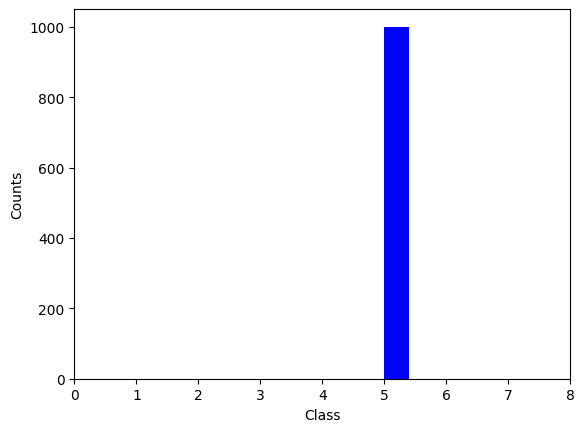

In [ ]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist([x[0] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

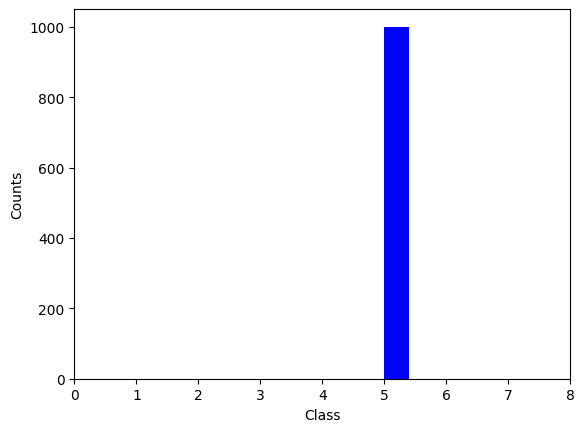

In [ ]:
n, bins, patches = plt.hist([x[1] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

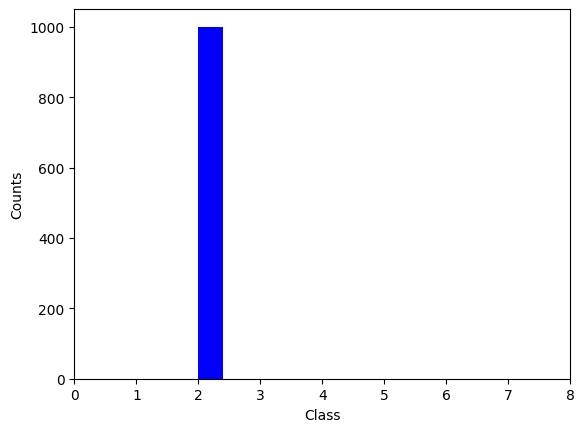

In [ ]:
n, bins, patches = plt.hist([x[2] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

---

Hmm... each time, we predicted the same class 1000 times, but we expected the dropout to provide some distribution of predictions. Suspicuous...

**Q4:** Is there a catch? Please write your thoughts on why we do not see a distribution and whether we could fix it somehow.

---

The issue we're encountering might be related to the way we're using dropout during testing. By default, when using model.eval(), dropout layers are set to evaluation mode and do not apply dropout during inference. This can lead to the same prediction being made for each forward pass, as dropout is not providing variability in predictions.

To enable dropout during testing and obtain a distribution of predictions, we can use the model.train() mode during the testing loop. However, since we're running multiple forward passes, we should also normalize the outputs to get a distribution. Here's how we can modify our testing loop:

In [ ]:
model.train()

preds = []
for idx in range(samples):
    preds.append(model(image).clone().detach().cpu().numpy())

preds = np.array(preds)

preds_normalized = preds / np.sum(preds, axis=2, keepdims=True)

pred_class = np.argmax(preds_normalized, axis=2)

pred_class_list = []
for idx in range(preds.shape[0]):
    pred_class_list.append(np.argmax(preds_normalized[idx], axis=1))
